# Imports

In [53]:
# Import necessary modules
import SpotCurve.Spot_Curve_Calculator as sc
import matplotlib.pyplot as plt
import pandas as pd
import mpl_bsic
import importlib
import Returns.RollDown as rd
from Utils.data_processing import process_data
import Utils.CrossSectional_Regression as csr
import numpy as np

# Reload modules to reflect any recent changes during development
importlib.reload(sc)
importlib.reload(rd)
importlib.reload(csr)

<module 'Utils.CrossSectional_Regression' from '/Users/vittoriomanfriani/PycharmProjects/backtesting series - episode 3/Utils/CrossSectional_Regression.py'>

# Load Data

In [3]:
# Read data from the Parquet file
data = pd.read_parquet('/Users/vittoriomanfriani/Desktop/BSIC/Datasets/bond_data_auction.parquet')

# Filter data to include only dates between 2010-01-01 and 2024-10-02
data = data.loc[
    (data.index.get_level_values(0) >= '2010-01-01') &
    (data.index.get_level_values(0) <= '2024-10-02')
]

# Apply Bootstrapper

In [4]:
spot_rates_calculator = sc.SpotRatesCalculator()
zero_curve_df = spot_rates_calculator.apply_bootstrapper(data,freq = 'tenors')

100%|██████████| 3847/3847 [02:33<00:00, 25.08it/s]


# Apply Nelson Siegel

In [19]:
loadings_df = spot_rates_calculator.apply_nelson_siegel(zero_curve_df, ridge=False)
loadings_df.head()

100%|██████████| 3847/3847 [00:18<00:00, 210.08it/s]


,Beta0 (Level),Beta1 (Slope),Beta2 (Curvature),Lambda
Date,,,,
2010-01-01,5.646371,-5.627147,-5.291566,1.417384
2010-01-04,5.691060,-5.555930,-5.843401,1.400962
2010-01-05,5.671465,-5.552925,-5.912948,1.421027
2010-01-06,5.772911,-5.680453,-6.032135,1.421147
2010-01-07,5.755704,-5.660230,-5.924907,1.422937


## Interpolate with Nelson-Siegel-Svensonn

In [51]:
interpolated_curve_df = spot_rates_calculator.interpolate_nelson_siegel(loadings_df, freq = 'quarterly')

100%|██████████| 3847/3847 [00:03<00:00, 1237.56it/s]


### Plot and compare the two curves

fonts already added so will not add again


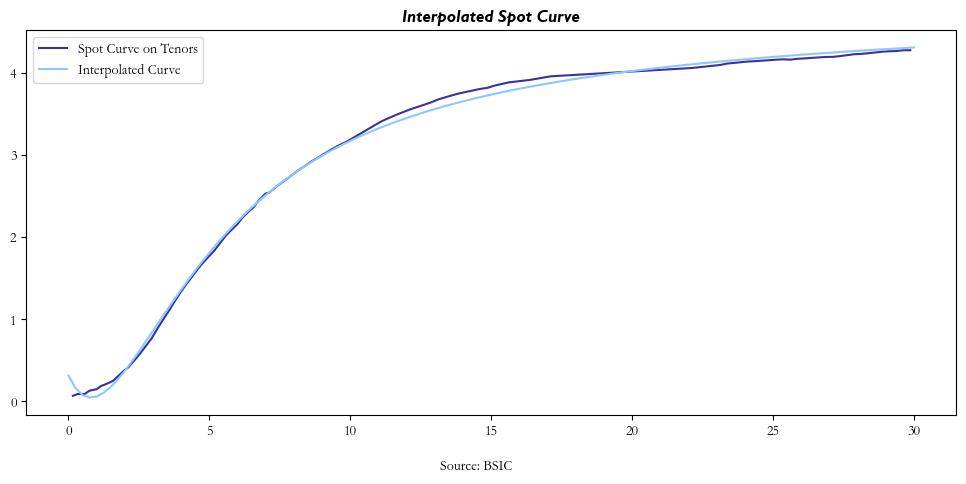

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot spot curve on tenors
ax.plot(
    zero_curve_df.loc['2014-01-01', 'Maturities'],
    zero_curve_df.loc['2014-01-01', 'Curve'],
    label='Spot Curve on Tenors'
)

# Plot interpolated curve
ax.plot(
    interpolated_curve_df.loc['2014-01-01', 'Maturities'],
    interpolated_curve_df.loc['2014-01-01', 'Curve'],
    label='Interpolated Curve'
)

# Add legend and title
ax.legend()
ax.set_title('Interpolated Spot Curve')

# Apply custom style
mpl_bsic.apply_bsic_style(fig, ax)

# Compute Returns

## Overall returns

In [10]:
# Function to compute returns
def compute_gross_returns(df):
    # Calculate daily coupons (coupon/365) and lagged price
    df['daily_coupons'] = df['coupon'] / 365
    df['prev_price'] = df.groupby('id')['price'].shift(1)  # Lagged price for each bond

    # Compute returns using the formula
    df['returns'] = ((df['price'] + df['daily_coupons']) - df['prev_price']) / df['prev_price']

    return df

In [11]:
data = process_data(data)
data = compute_gross_returns(data)

## Carry

In [12]:
def compute_carry(df):
    df['carry'] = df['daily_coupons'] / df['prev_price']
    return df

In [13]:
data = compute_carry(data)

## RollDown

In [14]:
data = rd.compute_rolldown(data)

Computing RollDown: 100%|█████████▉| 3846/3847 [05:41<00:00, 11.27it/s]


## Excess Returns

In [15]:
data['Excess Returns'] = data['returns'] - data['carry'] - data['rolldown']

# Cross Sectional Regression

In [54]:
params = csr.cross_sectional_regression_nelson_siegel(data, loadings_df, nss = False)
params.mean()

100%|██████████| 3847/3847 [00:06<00:00, 616.90it/s]


const        0.002017
beta1        0.004294
beta2       -0.015807
r_squared    0.777635
dtype: float64

# Systematic and Idio Returns

In [38]:
data = data.join(params, on='timestamp')

In [41]:
data = data.join(loadings_df, on='timestamp')

In [49]:
data['systematic returns'] = data['const'] + data['beta1']*((1 - np.exp(-data['time to maturity']/data['Lambda']))/(data['time to maturity']/data['Lambda'])) + data['beta2'] * ((1 - np.exp(-data['time to maturity'] / data['Lambda'])) / (data['time to maturity'] / data['Lambda']) - np.exp(-data['time to maturity'] / data['Lambda']))

data['idio returns'] = data['Excess Returns'] - data['systematic returns']

In [55]:
data[['Excess Returns', 'systematic returns', 'idio returns']].mean()

Excess Returns        5.653357e-04
systematic returns    5.649369e-04
idio returns         -4.576935e-07
dtype: float64